<a href="https://colab.research.google.com/github/stepanshulpin/nlp/blob/master/nlp_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задача https://pan.webis.de/clef14/pan14-web/author-profiling.html  
Определение пола и возраста автора**

Загрузка и перепаковка данных

In [0]:
!wget https://www.uni-weimar.de/medien/webis/corpora/corpus-pan-labs-09-today/pan-14/pan14-data/pan14-author-profiling-training-corpus-2014-04-16.zip
!unzip pan14-author-profiling-training-corpus-2014-04-16.zip
!mkdir data

!unzip pan14-author-profiling-training-corpus-2014-04-16/pan14-author-profiling-training-corpus-english-blogs-2014-04-16.zip
!rm pan14-author-profiling-training-corpus-2014-04-16/pan14-author-profiling-training-corpus-english-blogs-2014-04-16.zip
!mv mnt/nfs/tira/data/pan14-training-corpora-truth/pan14-author-profiling-training-corpus-english-blogs-2014-04-16 data/pan_english_blogs

!unzip pan14-author-profiling-training-corpus-2014-04-16/pan14-author-profiling-training-corpus-english-reviews-2014-04-16.zip
!rm pan14-author-profiling-training-corpus-2014-04-16/pan14-author-profiling-training-corpus-english-reviews-2014-04-16.zip
!mv mnt/nfs/tira/data/pan14-training-corpora-truth/pan14-author-profiling-training-corpus-english-reviews-2014-04-16 data/pan_english_reviews

!unzip pan14-author-profiling-training-corpus-2014-04-16/pan14-author-profiling-training-corpus-english-socialmedia-2014-04-16.zip
!rm pan14-author-profiling-training-corpus-2014-04-16/pan14-author-profiling-training-corpus-english-socialmedia-2014-04-16.zip
!mv mnt/nfs/tira/data/pan14-training-corpora-truth/pan14-author-profiling-training-corpus-english-socialmedia-2014-04-16 data/pan_english_socialmedia

!rm pan14-author-profiling-training-corpus-2014-04-16.zip

!wget https://s3.amazonaws.com/autoritas.pan/pan-AP14-test-2014-05-26.zip
!unzip pan-AP14-test-2014-05-26.zip
!mkdir test

!mv pan-AP14-test-2014-05-26/blogs/en test/pan_english_blogs
!mv pan-AP14-test-2014-05-26/reviews/en test/pan_english_reviews
!mv pan-AP14-test-2014-05-26/socialmedia/en test/pan_english_socialmedia

!mv pan-AP14-test-2014-05-26/blogs/en.txt test/pan_english_blogs/truth.txt
!mv pan-AP14-test-2014-05-26/reviews/en.txt test/pan_english_reviews/truth.txt
!mv pan-AP14-test-2014-05-26/socialmedia/en.txt test/pan_english_socialmedia/truth.txt

!rm pan-AP14-test-2014-05-26.zip

In [2]:
!ls test

pan_english_blogs  pan_english_reviews	pan_english_socialmedia


In [0]:
import os
from xml.dom import minidom
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

Парсинг xml, очистка текста от тегов

In [0]:
def getTexts(directory, authorFileName, textsCount):
    file = directory+"/"+authorFileName
    xmldoc = minidom.parse(file)
    rawdocuments = xmldoc.getElementsByTagName('document')
    ner_length = 0
    vocabulary = list()
    for document in rawdocuments:
        rawText = removeTag_CDATA_section(document.firstChild.nodeValue.strip())
        vocabulary.append(rawText)
        textsCount = textsCount + 1
    return vocabulary, textsCount

def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res

def removeTag_CDATA_section(text):
    processedText = re.sub(r'<[^>]*>','',text,0)
    processedText = re.sub(r'&amp;','&',processedText,0)
    processedText = re.sub(r'&ldquo;','"',processedText,0)
    processedText = re.sub(r'&rdquo;','"',processedText,0)
    processedText = re.sub(r'&rsquo;',"'",processedText,0)
    processedText = re.sub(r'&nbsp;','',processedText,0)
    return processedText

def getAuthorInfo(truth_file):
    ifile = open(truth_file)
    truth_data = ifile.readlines()
    author_info = {}
    for line in truth_data:
        element = line.strip().split(":::")
        author_info[element[0]] = [element[1],element[2]]
    ifile.close()
    return author_info


def getAuthorTexts(directory, authorFileNames, author, textsCount):
    for file in authorFileNames:
      if file.endswith(".xml"):        
        key = file.split('.')[0]
        author[key], textsCount = getTexts(directory, file, textsCount)
    return author, textsCount

def getTestAuthorTexts(directory, authorFileNames, author, textsCount):
    for file in authorFileNames:
      if file.endswith(".xml"):
        key = file.replace('_en_xx_xx.xml','')
        author[key], textsCount = getTexts(directory, file, textsCount)
    return author, textsCount

Загрузка тренировочной выборки в DataFrame

In [5]:
directory_blogs = 'data/pan_english_blogs'
truth_file_blogs = 'data/pan_english_blogs/truth.txt'

directory_reviews = 'data/pan_english_reviews'
truth_file_reviews = 'data/pan_english_reviews/truth.txt'

directory_socialmedia = 'data/pan_english_socialmedia'
truth_file_socialmedia = 'data/pan_english_socialmedia/truth.txt'

textsCount = 0

author = {}
author_info = Merge(Merge(getAuthorInfo(truth_file_blogs), getAuthorInfo(truth_file_reviews)), getAuthorInfo(truth_file_socialmedia))
#author_info = getAuthorInfo(truth_file_socialmedia)

author, textsCount = getAuthorTexts(directory_blogs, os.listdir(directory_blogs), author, textsCount)
author, textsCount = getAuthorTexts(directory_reviews, os.listdir(directory_reviews), author, textsCount)
author, textsCount = getAuthorTexts(directory_socialmedia, os.listdir(directory_socialmedia), author, textsCount)

train = pd.DataFrame(data=0,columns = ["Gender","Age",'Text','AuthorId'], index=range(textsCount))

index = 0

for authorId, texts in author.items():
  author_frame = list()
  start = index
  for text in texts:
    author_frame.append([author_info[authorId][0], author_info[authorId][1], text, authorId])
    index = index + 1
    if index % 1000 == 0:
      print('{}/{}'.format(index, textsCount))
  end = index - 1
  train.loc[start:end] = author_frame
train.fillna(0)
train.describe()
train.head()

1000/154573
2000/154573
3000/154573
4000/154573
5000/154573
6000/154573
7000/154573
8000/154573
9000/154573
10000/154573
11000/154573
12000/154573
13000/154573
14000/154573
15000/154573
16000/154573
17000/154573
18000/154573
19000/154573
20000/154573
21000/154573
22000/154573
23000/154573
24000/154573
25000/154573
26000/154573
27000/154573
28000/154573
29000/154573
30000/154573
31000/154573
32000/154573
33000/154573
34000/154573
35000/154573
36000/154573
37000/154573
38000/154573
39000/154573
40000/154573
41000/154573
42000/154573
43000/154573
44000/154573
45000/154573
46000/154573
47000/154573
48000/154573
49000/154573
50000/154573
51000/154573
52000/154573
53000/154573
54000/154573
55000/154573
56000/154573
57000/154573
58000/154573
59000/154573
60000/154573
61000/154573
62000/154573
63000/154573
64000/154573
65000/154573
66000/154573
67000/154573
68000/154573
69000/154573
70000/154573
71000/154573
72000/154573
73000/154573
74000/154573
75000/154573
76000/154573
77000/154573
78000/15

,Gender,Age,Text,AuthorId
0,FEMALE,35-49,It had to end. Just like we&#8217;ve all exper...,0a485d9bc555d607f43264a186fb2396
1,FEMALE,35-49,How do you meet people? Believe&#8230;Feast&#8...,0a485d9bc555d607f43264a186fb2396
2,FEMALE,35-49,It&#8217;s true: Marketing your book is hard w...,0a485d9bc555d607f43264a186fb2396
3,FEMALE,35-49,This is mine. One of the challenges most reluc...,0a485d9bc555d607f43264a186fb2396
4,FEMALE,35-49,"But first, let&#8217;s talk about your vision ...",0a485d9bc555d607f43264a186fb2396


Загрузка тестовой выборки в DataFrame

In [6]:
directory_blogs = 'test/pan_english_blogs'
truth_file_blogs = 'test/pan_english_blogs/truth.txt'

directory_reviews = 'test/pan_english_reviews'
truth_file_reviews = 'test/pan_english_reviews/truth.txt'

directory_socialmedia = 'test/pan_english_socialmedia'
truth_file_socialmedia = 'test/pan_english_socialmedia/truth.txt'

textsCount = 0

author = {}
author_info = Merge(Merge(getAuthorInfo(truth_file_blogs), getAuthorInfo(truth_file_reviews)), getAuthorInfo(truth_file_socialmedia))
#author_info = getAuthorInfo(truth_file_socialmedia)

author, textsCount = getTestAuthorTexts(directory_blogs, os.listdir(directory_blogs), author, textsCount)
author, textsCount = getTestAuthorTexts(directory_reviews, os.listdir(directory_reviews), author, textsCount)
author, textsCount = getTestAuthorTexts(directory_socialmedia, os.listdir(directory_socialmedia), author, textsCount)

test = pd.DataFrame(data=0,columns = ["Gender","Age",'Text','AuthorId'], index=range(textsCount))

index = 0

for authorId, texts in author.items():
  author_frame = list()
  start = index
  for text in texts:
    author_frame.append([author_info[authorId][0], author_info[authorId][1], text, authorId])
    index = index + 1
    if index % 1000 == 0:
      print('{}/{}'.format(index, textsCount))
  end = index - 1
  test.loc[start:end] = author_frame
test.fillna(0)
test.describe()
test.head()

1000/84189
2000/84189
3000/84189
4000/84189
5000/84189
6000/84189
7000/84189
8000/84189
9000/84189
10000/84189
11000/84189
12000/84189
13000/84189
14000/84189
15000/84189
16000/84189
17000/84189
18000/84189
19000/84189
20000/84189
21000/84189
22000/84189
23000/84189
24000/84189
25000/84189
26000/84189
27000/84189
28000/84189
29000/84189
30000/84189
31000/84189
32000/84189
33000/84189
34000/84189
35000/84189
36000/84189
37000/84189
38000/84189
39000/84189
40000/84189
41000/84189
42000/84189
43000/84189
44000/84189
45000/84189
46000/84189
47000/84189
48000/84189
49000/84189
50000/84189
51000/84189
52000/84189
53000/84189
54000/84189
55000/84189
56000/84189
57000/84189
58000/84189
59000/84189
60000/84189
61000/84189
62000/84189
63000/84189
64000/84189
65000/84189
66000/84189
67000/84189
68000/84189
69000/84189
70000/84189
71000/84189
72000/84189
73000/84189
74000/84189
75000/84189
76000/84189
77000/84189
78000/84189
79000/84189
80000/84189
81000/84189
82000/84189
83000/84189
84000/84189


,Gender,Age,Text,AuthorId
0,FEMALE,35-49,Need a cover letter? Now you can read &#8211; ...,4feed6faa3678318479ef2531c8bee70
1,FEMALE,35-49,Don&#8217;t be. You can&#8217;t grab the brass...,4feed6faa3678318479ef2531c8bee70
2,FEMALE,35-49,"After the interview, it’s time to hand-write a...",4feed6faa3678318479ef2531c8bee70
3,FEMALE,35-49,There it is! The perfect job. The one you hope...,4feed6faa3678318479ef2531c8bee70
4,FEMALE,35-49,How do you meet people? Believe&#8230;Feast&#8...,4feed6faa3678318479ef2531c8bee70


Токенизация используя spacy

In [0]:
punctuations = string.punctuation

nlp = English()
stop_words = STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    # Lemmatization - rip words to their lemma equivalent
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # Rip out the stop words and punctuations
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

In [0]:
class TextPreprocessor(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def clean_text(text):
    return text.strip().lower()

In [0]:
train['Gender'].replace(['FEMALE','MALE'], [0,1], inplace=True)
test['Gender'].replace(['FEMALE','MALE'], [0,1], inplace=True)

In [2]:
test.head()

NameError: ignored

In [0]:
X_train = train['Text']
y_train = train['Gender']
y_train_age = train['Age']
X_test = test['Text']
y_test = test['Gender']
y_test_age = test['Age']

Pipeline для определения пола автора

In [50]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf = TfidfTransformer()

classifier = LogisticRegression()

pipe = Pipeline([("cleaner", TextPreprocessor()),
                 ('vectorizer', bow_vector),
                 ('tfid', tfidf),
                 ('classifier', classifier)], verbose=True)

pipe.fit(X_train,y_train)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   1.0s
[Pipeline] ........ (step 2 of 4) Processing vectorizer, total=13.4min
[Pipeline] .............. (step 3 of 4) Processing tfid, total=   4.6s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=  43.7s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('cleaner',
                 <__main__.TextPreprocessor object at 0x7f13a845d828>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=...
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [51]:
predicted = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, predicted))

Accuracy: 0.5232750121749873


Pipeline для определения возраста автора

In [22]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf = TfidfTransformer()

classifier = LogisticRegression()

pipe = Pipeline([("cleaner", TextPreprocessor()),
                 ('vectorizer', bow_vector),
                 ('tfid', tfidf),
                 ('classifier', classifier)], verbose=True)

pipe.fit(X_train,y_train_age)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.7s
[Pipeline] ........ (step 2 of 4) Processing vectorizer, total=12.4min
[Pipeline] .............. (step 3 of 4) Processing tfid, total=   4.2s
[Pipeline] ........ (step 4 of 4) Processing classifier, total= 2.6min


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('cleaner',
                 <__main__.TextPreprocessor object at 0x7fafc8f90c18>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=...
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [0]:
predicted = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_age, predicted))

Accuracy: 0.3353882336172184


Для задачи определения пола точность - 0.52, определения возраста - 0.33  
Если сравнивать с результатами, предсталенными на PAN, то точность неплохая
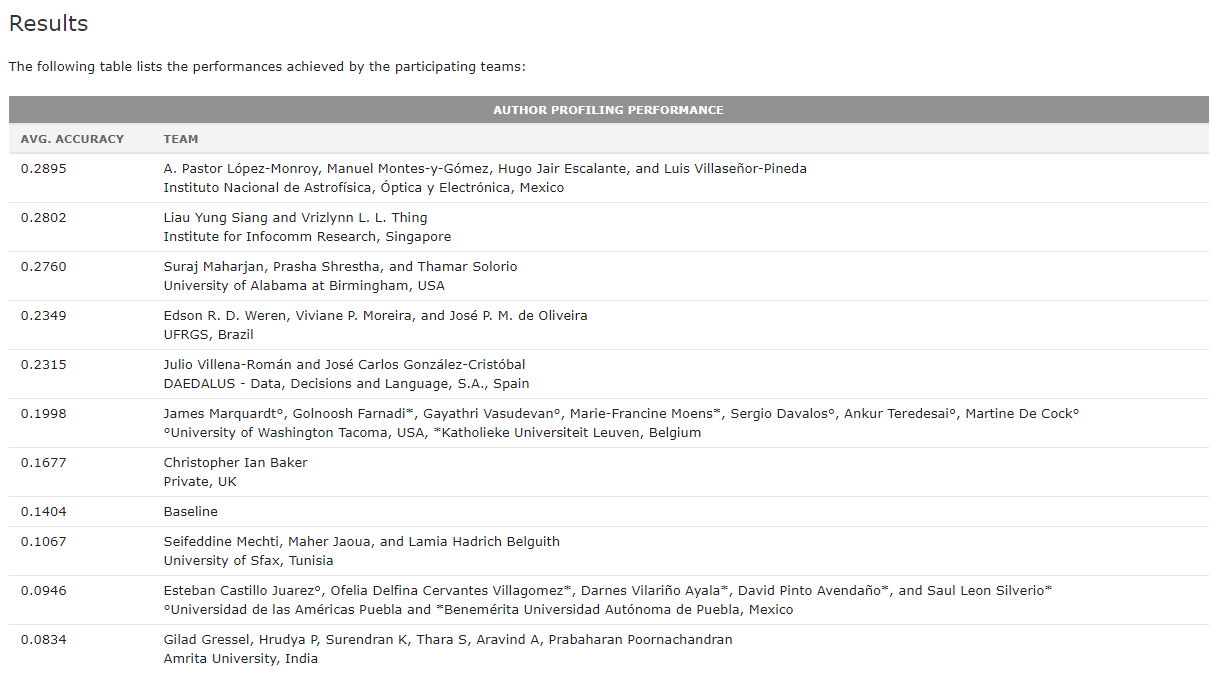

In [11]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf = TfidfTransformer()

classifier = MultinomialNB()

pipe = Pipeline([("cleaner", TextPreprocessor()),
                 ('vectorizer', bow_vector),
                 ('tfid', tfidf),
                 ('classifier', classifier)], verbose=True)

pipe.fit(X_train,y_train_age)

[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.9s
[Pipeline] ........ (step 2 of 4) Processing vectorizer, total=12.7min
[Pipeline] .............. (step 3 of 4) Processing tfid, total=   4.5s
[Pipeline] ........ (step 4 of 4) Processing classifier, total=   1.2s


Pipeline(memory=None,
         steps=[('cleaner',
                 <__main__.TextPreprocessor object at 0x7f1ff5c09e48>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x7f1ff4adf378>,
                                 vocabulary=None)),
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),

In [12]:
predicted = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_age, predicted))

Accuracy: 0.3333333333333333


In [0]:
!pip install zeugma

In [16]:
from zeugma.embeddings import EmbeddingTransformer
glove = EmbeddingTransformer('glove')
glove.fit(X_test)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


EmbeddingTransformer(aggregation='average',
                     model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f1f96713b00>)

In [0]:
classifier = LogisticRegression()

pipe = Pipeline([("cleaner", TextPreprocessor()),
                 ('glove', glove),
                 ('classifier', classifier)], verbose=True)

pipe.fit(X_train,y_train_age)

In [0]:
predicted = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_age, predicted))